# CTC based ASR

В этом семинаре обучим модель распознавания речи.

    - Препроцессинг данных
    - Зададим простую модель
    - Обучим модель с CTC лоссом 
    - Измерим качество используя метрику CER

In [2]:
from IPython import display
from matplotlib import pyplot as plt
from collections import defaultdict

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset

import torchaudio
from torchaudio.transforms import MelSpectrogram



In [26]:
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    if wav.dim() == 2:
        wav = wav.mean(dim=0)
    
    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()
    
    display.display(display.Audio(wav, rate=sr))

# Data

Это датасет чисел 0 to 999_999, произнесенных на русском языке.
В датасете спикеры разного пола и возраста.

In [4]:
!wget https://raw.githubusercontent.com/markovka17/apdl/master/gfile.py

--2022-05-26 14:54:29--  https://raw.githubusercontent.com/markovka17/apdl/master/gfile.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3423 (3.3K) [text/plain]
Saving to: ‘gfile.py’

gfile.py            100%[===================>]   3.34K  --.-KB/s    in 0s      

2022-05-26 14:54:29 (34.1 MB/s) - ‘gfile.py’ saved [3423/3423]



In [14]:
!rm -rf data

In [15]:
!wget wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1HKtLLbiEk0c3l1mKz9LUXRAmKd3DvD0P' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1HKtLLbiEk0c3l1mKz9LUXRAmKd3DvD0P" -O numbers.zip && rm -rf /tmp/cookies.txt

--2022-05-26 14:59:26--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2022-05-26 14:59:26--  https://docs.google.com/uc?export=download&confirm=t&id=1HKtLLbiEk0c3l1mKz9LUXRAmKd3DvD0P
Resolving docs.google.com (docs.google.com)... 209.85.146.113, 209.85.146.100, 209.85.146.101, ...
Connecting to docs.google.com (docs.google.com)|209.85.146.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i33itvkov6hmlpbnumaqte42i78k4q6u/1653577125000/05353592946685554048/*/1HKtLLbiEk0c3l1mKz9LUXRAmKd3DvD0P?e=download [following]
--2022-05-26 14:59:26--  https://doc-14-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i33itvkov6hmlpbnumaqte42i78k4q6u/1653577125000/05353592946685554048/*/1HKtLLbiEk0c3l1mKz9LUXRAmKd3DvD0P?e=download
Resolving doc-14-3s-docs.googleusercontent.com 

In [18]:
!unzip numbers.zip 

Streaming output truncated to the last 5000 lines.
  inflating: numbers/train/801651b0f6.wav  
  inflating: numbers/train/ede78d6a0a.wav  
  inflating: numbers/train/a843ab4929.wav  
  inflating: numbers/train/2acd9902a2.wav  
  inflating: numbers/train/057af5ead7.wav  
  inflating: numbers/train/f8e00659fc.wav  
  inflating: numbers/train/b46faf7d70.wav  
  inflating: numbers/train/591dceff39.wav  
  inflating: numbers/train/2b1716688e.wav  
  inflating: numbers/train/6093d3673f.wav  
  inflating: numbers/train/309528b196.wav  
  inflating: numbers/train/bc056ce093.wav  
  inflating: numbers/train/7e9e79ece9.wav  
  inflating: numbers/train/22e33c6bef.wav  
  inflating: numbers/train/90c3173913.wav  
  inflating: numbers/train/e1c73df0c5.wav  
  inflating: numbers/train/2914431f40.wav  
  inflating: numbers/train/460a17e170.wav  
  inflating: numbers/train/fd5b2030a6.wav  
  inflating: numbers/train/a3467aa48a.wav  
  inflating: numbers/train/b2c6a803fd.wav  
  inflating: numbers/trai

Конвертируем все данные к одинаковому sample_rate=16000, и преобразуем ответы к определенному виду. Например, если произнесено число 123, то ответом будет: y = [1,2,3].

Для этого создадим класс `SpeechDataset`.

In [20]:
import os

import pandas as pd
import numpy as np


class SpeechDataset(Dataset):
    
    SAMPLE_RATE = 16000
    _ROOT_PREFIX = 'numbers'

    def __init__(self, path_to_csv: str):
        self.path_to_csv = path_to_csv

        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)

    @staticmethod
    def number2digits(number: np.ndarray) -> torch.Tensor:
        digits = list(map(int, list(str(number))))
        return torch.LongTensor(digits)

    def __getitem__(self, index: int):
        output = self.csv.iloc[index]
        
        if len(output) == 3:
            path, gender, number = output
            y = self.number2digits(number)
        else:
            path, = output
            y = torch.LongTensor([-1])

        path = os.path.join(self._ROOT_PREFIX, path)

        wav, sr = torchaudio.load(path)
        if sr != self.SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(sr, self.SAMPLE_RATE)
            wav = resampler(wav)
        
        wav = wav.squeeze()

        instance = {
            'path': path,
            'x': wav,
            'y': y
        }

        return instance

    def __len__(self):
        return self.csv.shape[0]

Случайно разобъем датасет на `train` и `validation`.

In [22]:
dataset = SpeechDataset('numbers/train.csv')

train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)
random_indexes = torch.randperm(len(dataset)).tolist()

train_dataset = Subset(dataset, random_indexes[:train_size])
val_dataset = Subset(dataset, random_indexes[train_size:])

In [23]:
len(train_dataset), len(val_dataset)

(8100, 900)

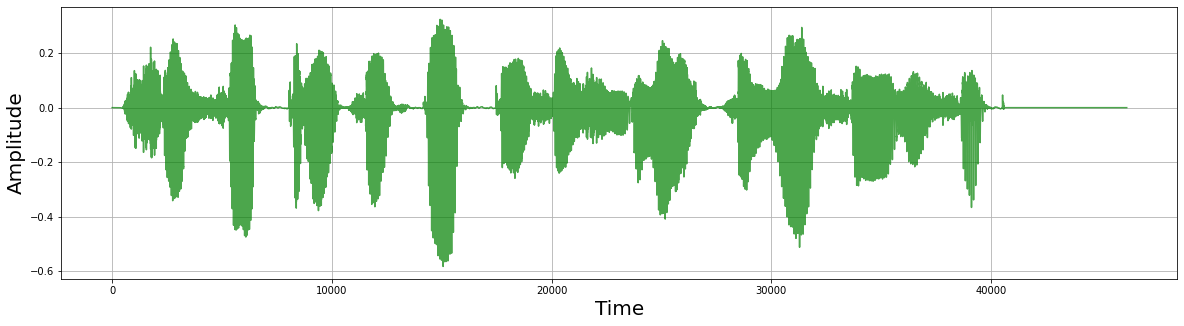

In [27]:
instance = train_dataset[0]
visualize_audio(instance['x'], dataset.SAMPLE_RATE)

In [28]:
instance['y']

tensor([6, 3, 5, 2, 8, 0])

Так как датасет состоит из чисел от 0 до 999999, таргеты имеют разную длину. Зададим паддинг, чтобы все ответы имели одинаковую длину.  Если ответ имеет меньше 6 цифр, заполним недостаующие до 6 ячейки '10':

    123456 -> y = [1, 2, 3, 4, 5, 6]

    123    -> y = [1, 2, 3, 10, 10, 10]

In [29]:
from tqdm import tqdm
from itertools import islice


class PaddingCollator:

    def __call__(self, instances):
        
        batch_size = len(instances)
        x_len = torch.LongTensor([instance['x'].size(0) for instance in instances])
        y_len = torch.LongTensor([instance['y'].size(0) for instance in instances])
        path = [instance['path'] for instance in instances]

        x = torch.zeros(batch_size, max(x_len), dtype=torch.float32)
        y = torch.zeros(batch_size, max(y_len), dtype=torch.long)
        y.fill_(10)  # 10 -- padding

        for i, instance in enumerate(instances):
            x[i, :x_len[i]] = instance['x']
            y[i, :y_len[i]] = instance['y']

        instance = {
            'x': x,
            'y': y,
            'x_len': x_len,
            'y_len': y_len,
            'path': path
        }
        
        return instance

In [30]:
train_dataloader = DataLoader(
    train_dataset, 64,
    collate_fn=PaddingCollator(), shuffle=True,
#     pin_memory=True, num_workers=2
)
val_dataloader = DataLoader(
    val_dataset, 32, collate_fn=PaddingCollator(),
#     pin_memory=True, num_workers=2
)

Посмотрим, что получилось в батче

In [31]:
batch = list(islice(val_dataloader, 1))[0]
batch['x'][:2, :]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [32]:
batch['y'][:2, :]

tensor([[9, 4, 2, 9, 5, 8],
        [1, 3, 4, 7, 2, 5]])

In [33]:
batch.keys()

dict_keys(['x', 'y', 'x_len', 'y_len', 'path'])

# Feature Extraction

Example of obtaining a (mel) spectrogram from a signal: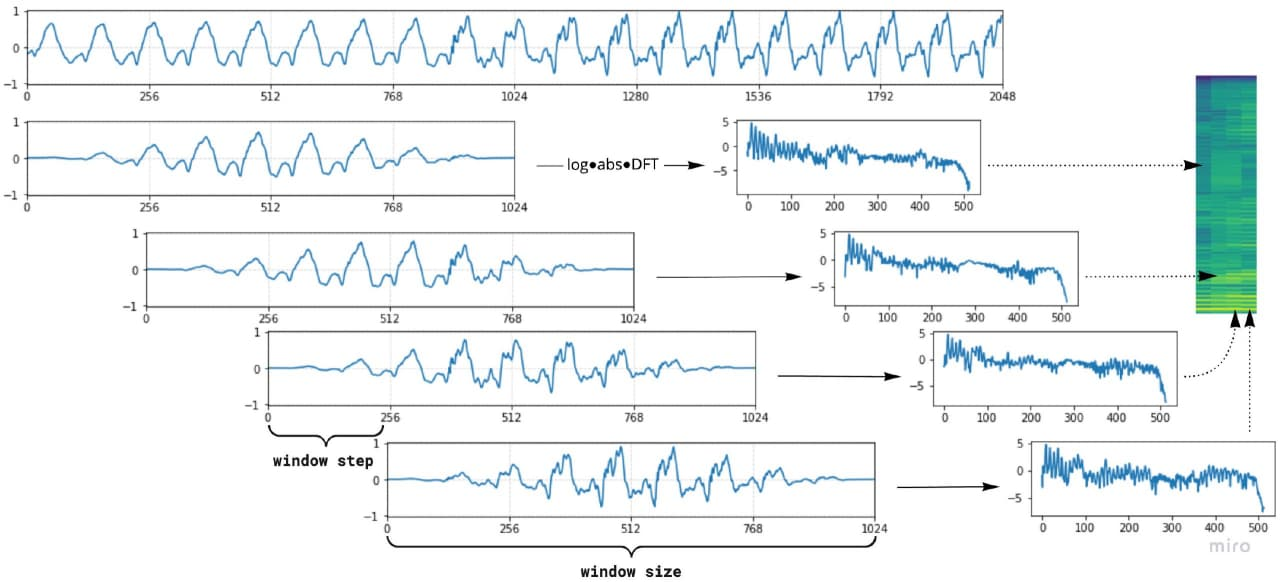

In [34]:
def apply_compression(melspec):
    # Add eps=1e-7 to avoid log(0)
    return torch.log(melspec.clamp(1e-5))

In [35]:
class Featurizer(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.featurizer = MelSpectrogram(
            sample_rate=train_dataset.dataset.SAMPLE_RATE,
            n_fft=1024,
            win_length=1024,
            hop_length=256,
            n_mels=64,
            power=1
        )
    
    def forward(self, x, x_len=None):
        x = self.featurizer(x)
        x = apply_compression(x)
        
        # Convert the length from wav dimension to spectrogram dimension
        if x_len is not None:
            x_len = ((x_len + 1).float() / self.featurizer.hop_length).ceil().long()
            return x, x_len
        
        return x

## Model

Напишем небольшую модель, основанную на блоках модели QuartzNet https://arxiv.org/pdf/1910.10261.pdf

In [36]:
from torch import nn


class QuartzBlock(nn.Module):
    """
    Basic block of QuartzNet consisting of Separable Convolution, BatchNorm and ReLU repeating R times
    
    :param in_channels: number of input channels
    :param hidden_channels: number of hidden and output channels
    :param kernel_size: size of kernels
    :param repeat: number of repetitions of block constituents
    """
    
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        kernel_size: int = 33,
        repeat: int = 4,
    ):
        super().__init__()
        
        self.repeat = repeat
        self.blocks = nn.ModuleList([
            nn.ModuleList([
                nn.Conv1d(
                    in_channels=in_channels if i == 0 else hidden_channels,
                    out_channels=hidden_channels,
                    kernel_size=kernel_size,
                    groups=in_channels if i == 0 else hidden_channels,
                    padding=kernel_size // 2
                ),
                nn.Conv1d(hidden_channels, hidden_channels, kernel_size=1),
                nn.BatchNorm1d(hidden_channels),
                nn.ReLU(),
            ])
            for i in range(repeat)
        ])
        self.res_conv = nn.Sequential(  # convolution for residual
            nn.Conv1d(in_channels, hidden_channels, kernel_size=1),
            nn.BatchNorm1d(hidden_channels),
        )

    def forward(self, x):
        x_initial = x
        
        for i, block in enumerate(self.blocks):
            for j, layer in enumerate(block):
                # If not last ReLU
                if not (i == (len(self.blocks) - 1) and j ==( len(block) - 1)):
                    x = layer(x)
                else:
                    # Pass residual
                    x = x + self.res_conv(x_initial)
                    x = layer(x)
        return x



In [37]:
class DummyModel(nn.Module):

    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        self.prenet = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, 33, padding=33 // 2, stride=2),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU()
        )
        
        self.net = nn.Sequential(
            QuartzBlock(hidden_channels, hidden_channels),
            QuartzBlock(hidden_channels, hidden_channels * 2),

            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, 33,
                      padding=33 // 2, stride=2),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),

            QuartzBlock(hidden_channels * 2, hidden_channels * 4)
        )
        self.classifier = nn.Sequential(
            nn.Conv1d(hidden_channels * 4, out_channels, kernel_size=1),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x, x_len):
        x = self.prenet(x)
        x = self.net(x)
        return self.classifier(x), x_len // 4

# DummyModel(64, 128, 10 + 1)

## Посчитаем CER (character error rate)

Можно посчитать и другую метрику, например (WER, word error rate): https://www.rev.ai/blog/how-to-calculate-word-error-rate/

In [38]:
!pip install Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 5.2 MB/s 
     |████████████████████████████████| 1.8 MB 56.2 MB/s 
     |████████████████████████████████| 103 kB 50.6 MB/s 


Один из простейших способов декодирования предсказаний для модели, обученной с `CTC` лоссом это склеить повторяющиеся символы и удалить пустые:

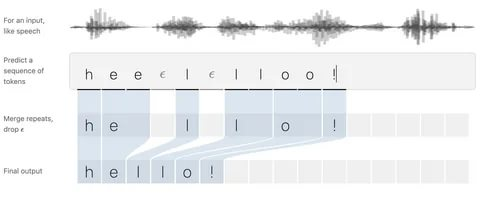

In [39]:
import Levenshtein


def ctc_decode(sequence, black_symbol=10):
    """
    Decode hypotheses
        1) Remove repetitive letters
        2) Remove blank characters
    """
    
    current = []
    for i in range(0, len(sequence)):
        symbol = sequence[i]

        if i > 0 and symbol == sequence[i - 1]:
            continue

        # skip blank symbol
        if symbol == black_symbol:
            continue

        current.append(str(int(symbol)))

    text = ''.join(current)
    return text


def calculate_cer(targets, decodings, padding_value=10):
    """
    Calculate the Levenshtein distance between predictions and GT
    """
    
    cer = 0.0
    targets = targets.detach().cpu().tolist()

    pairs = []
    for target, d in zip(targets, decodings):
        target = [c for c in target if c != padding_value]
        target = "".join(map(str, target))

        decoding = ctc_decode(d.tolist())
        cer += min(1, Levenshtein.distance(target, decoding) / (len(decoding) + 1e-7))

        pairs.append(
            target + '\t\t' + decoding
        )

    return cer / len(target), pairs

## Training

In [40]:
class AverageMeter:
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [41]:
NUM_EPOCH = 20
DEVICE = torch.device('cuda:0')

model = DummyModel(64, 128, 10 + 1).to(DEVICE)
mel_featurizer = Featurizer().to(DEVICE)
criterion = nn.CTCLoss(blank=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

In [42]:
history = defaultdict(list)

In [ ]:
for epoch in range(NUM_EPOCH):

    average_cer = AverageMeter()
    average_loss = AverageMeter()
    
    for batch in train_dataloader:
        x = batch['x'].to(DEVICE)
        y = batch['y'].to(DEVICE)
        x_len = batch['x_len'].to(DEVICE)
        y_len = batch['y_len'].to(DEVICE)
        
        x, x_len = mel_featurizer(x, x_len)
        
        log_probs, x_len = model(x, x_len)
        
        # B, C, T -> T, B, C
        log_probs = log_probs.permute(2, 0, 1)
        loss = criterion(log_probs, y, x_len, y_len)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # T, B, C -> T, B -> B, T
        argmax_decoding = log_probs.detach().cpu() \
            .argmax(dim=-1).transpose(0, 1)

        cer, pairs = calculate_cer(y, argmax_decoding)

        average_cer.update(cer)
        average_loss.update(loss.item())

        history['loss'].append(average_loss.avg)
        history['cer'].append(average_cer.avg)
    
    display.clear_output()
    print(f'Epoch: {epoch}')
    for i in range(5):
        print(f'Example of prediction: ', pairs[i].replace("\t\t", " -> "))
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].plot(history['loss'], label='Loss')
    axes[1].plot(history['cer'], label='CER')
    axes[0].legend(); axes[0].grid()
    axes[1].legend(); axes[1].grid()
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


## Что дальше?

    1) Добавьте аугментации из предыдущего семинара

    2) Попробуйте улучшить качество модели. Например, увеличить сжатие вдоль временной оси.
    3) Translate numbers into letters and train letter recognition model (overkill :))
    4) Добавить специальный символ между цифрами, определяющий порядок (тысячи, сотни)
